In [1]:
import sys

sys.path.append("./..")

In [2]:
import pandas as pd

In [3]:
image_df = pd.read_csv("../test/test_image_meta.csv", index_col=0)

In [6]:
image_df.path = "../dataset/train_768x768/" + image_df.id + "_image.png"

In [7]:
import shutil
from pathlib import Path

test_path = Path("../test")
for file in image_df.path:
    shutil.copy(file, test_path / Path(file).name)

In [3]:
import tensorflow as tf
import tensorflow_hub as tfhub

In [4]:
tf.__version__

'2.4.0'

In [4]:
devices = tf.config.list_physical_devices()
tf.config.experimental.set_memory_growth(
    devices[1], True
)

2022-02-25 16:44:36.481906: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-25 16:44:36.482757: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-25 16:44:36.514813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 16:44:36.514951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design computeCapability: 7.5
coreClock: 1.335GHz coreCount: 24 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 268.26GiB/s
2022-02-25 16:44:36.514966: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-25 16:44:36.516622: I tensorflow/stream

In [5]:
def read_tf_image(path, target_size=(768, 768)):
    file_bytes = tf.io.read_file(path)
    img = tf.image.decode_png(file_bytes, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, target_size)
    return img

In [6]:
img = read_tf_image("../test/ccdbe0112d6f_image.png")

In [7]:
img.shape

TensorShape([768, 768, 3])

In [8]:
plt.imshow(img)

NameError: name 'plt' is not defined

In [8]:
MODEL_ARCH_PATH = "../models/configs/tf_hub_effv2/"

# Custom wrapper class to load the right pretrained weights explicitly from the local directory
class KerasLayerWrapper(tfhub.KerasLayer):
    def __init__(self, handle, **kwargs):
        handle = tfhub.KerasLayer(tfhub.load(MODEL_ARCH_PATH))
        super().__init__(handle, **kwargs)

In [9]:
MODEL_PATH = "../models/weights/efficient-classifer"

with tf.device('/device:CPU:0'):
    models = []
    models0 = tf.keras.models.load_model(f'{MODEL_PATH}/model0.h5',
                                         custom_objects={'KerasLayer': KerasLayerWrapper})
    # models1 = tf.keras.models.load_model(f'{MODEL_PATH}/model1.h5',
    #                                      custom_objects={'KerasLayer': KerasLayerWrapper})
    # models2 = tf.keras.models.load_model(f'{MODEL_PATH}/model2.h5',
    #                                      custom_objects={'KerasLayer': KerasLayerWrapper})
    # models3 = tf.keras.models.load_model(f'{MODEL_PATH}/model3.h5',
    #                                      custom_objects={'KerasLayer': KerasLayerWrapper})
    # models4 = tf.keras.models.load_model(f'{MODEL_PATH}/model4.h5',
    #                                      custom_objects={'KerasLayer': KerasLayerWrapper})
    models.append(models0)
    # models.append(models1)
    # models.append(models2)
    # models.append(models3)
    # models.append(models4)

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


In [17]:
pred = sum([model.predict(tf.expand_dims(img, axis=0)) for model in models]) / len(models)

In [14]:
label_cols = ['negative', 'typical', 'indeterminate', 'atypical']

In [18]:
pred

array([[0.00218544, 0.8921496 , 0.09362283, 0.01204208]], dtype=float32)

In [19]:
pred.argmax()

1

In [21]:
pred = pred[0][pred.argmax()]

In [22]:
pred

0.8921496

In [15]:
pred = label_cols[pred.argmax()]

In [41]:
pred

'typical'

In [26]:
tf.config.list_physical_devices('GPU')

[]

In [23]:
tf.expand_dims(img, 0).shape

TensorShape([1, 768, 768, 3])

In [8]:
image_df.path

5062    ../dataset/train_768x768/ccdbe0112d6f_image.png
3438    ../dataset/train_768x768/8bf7d61dddb4_image.png
5706    ../dataset/train_768x768/e5555f29a9a1_image.png
789     ../dataset/train_768x768/1ff2da663fc5_image.png
1007    ../dataset/train_768x768/29087adf8365_image.png
2129    ../dataset/train_768x768/5687abeb8010_image.png
3837    ../dataset/train_768x768/9be97a2b7f90_image.png
2445    ../dataset/train_768x768/63aefefa9ee0_image.png
3699    ../dataset/train_768x768/95be342e48de_image.png
2740    ../dataset/train_768x768/6f90c979c527_image.png
2290    ../dataset/train_768x768/5ce90616364e_image.png
6087    ../dataset/train_768x768/f6462d1bf586_image.png
2576    ../dataset/train_768x768/685ec8f1aa86_image.png
1126    ../dataset/train_768x768/2df3529c0288_image.png
3066    ../dataset/train_768x768/7c0d62261831_image.png
3646    ../dataset/train_768x768/939862cb5fa4_image.png
3566    ../dataset/train_768x768/9027e541f1f3_image.png
5668    ../dataset/train_768x768/e3c5df807bcb_im

In [3]:
from api.models import CovidDetectron


img = CovidDetectron.inference("../test/ccdbe0112d6f_image.png")

Loading weights from: ../models/weights/cascade_rcnn_best_epoch.pth
load checkpoint from local path: ../models/weights/cascade_rcnn_best_epoch.pth


/workspace/mmdetection/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


Model Loaded...


/workspace/mmdetection/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


In [7]:
import cv2
import matplotlib.pyplot as plt

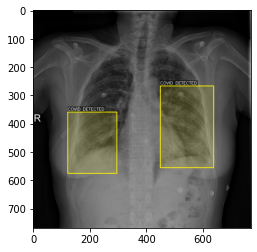

In [8]:
plt.imshow(img)

In [2]:
from api.models import CovidDiagnoser

result = CovidDiagnoser.inference("../test/ccdbe0112d6f_image.png")

2022-02-25 16:53:18.890873: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-25 16:53:21.239591: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-25 16:53:21.243379: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-25 16:53:21.276183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 16:53:21.276328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design computeCapability: 7.5
coreClock: 1.335GHz coreCount: 24 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 268.26GiB/s
2022-02-25 16:53:21.276341: I tensorflow/stream

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-02-25 16:53:40.672292: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-25 16:53:40.684481: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2894530000 Hz
2022-02-25 16:53:43.848370: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-02-25 16:53:44.133553: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-02-25 16:53:44.194413: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-02-25 16:53:46.310100: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near 

In [3]:
result

('Typical Appearance', 0.8921496)